#### TransposeConv2d
- an example from [here](https://towardsdatascience.com/understand-transposed-convolutions-and-build-your-own-transposed-convolution-layer-from-scratch-4f5d97b2967)

In [1]:
import torch.nn


conv2 = torch.nn.Conv2d(1, 1, 3, bias=False).float()
with torch.no_grad():
    # weight.shape = (# of out channels, # of in channels, 3, 3)
    weight = torch.Tensor([[1, 2, 1],
                           [2, 1, 2],
                           [1, 1, 2]]).view(1, 1, 3, 3).float()
    conv2.weight.copy_(weight)
# print(x.weight.shape)

inputs = torch.Tensor([[3, 5, 2, 7],
                       [4, 1, 3, 8],
                       [6, 3, 8, 2],
                       [9, 6, 1, 5]]).float()
inputs = inputs.view(1, 4, 4)
outputs = conv2(inputs)
print('Conv2d output:', outputs)
# if you consider `inputs` as a vector in R^16, the convolution operation can be considered a 4x16 matrix.
# outputs (in R^4) = (convolution matrix) x inputs (in R^4)

trancov2 = torch.nn.ConvTranspose2d(1, 1, 3, bias=False)
print('ConvTransposed2d weight shape:', trancov2.weight.shape)
with torch.no_grad():
    # the same weight that is used with Conv2d
    trancov2.weight.copy_(weight)
    trancov2.weight.copy_(weight)

backs = trancov2(outputs)
print(backs)

Conv2d output: tensor([[[55., 52.],
         [57., 50.]]], grad_fn=<SqueezeBackward1>)
ConvTransposed2d weight shape: torch.Size([1, 1, 3, 3])
tensor([[[ 55., 162., 159.,  52.],
         [167., 323., 319., 154.],
         [169., 264., 326., 204.],
         [ 57., 107., 164., 100.]]], grad_fn=<SqueezeBackward1>)


#### 1. ChallengeData2017
- this example detects only people
    - Origianl dataset have other classes too
- download the dataset from http://sceneparsing.csail.mit.edu/data/ChallengeData2017
- `tar -xv` and `mv` to ../data/ChallengeData2017/

In [2]:
# !wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
# !wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
# !tar -xf images.tar
# !tar -xf annotations_instance.tar
# !rm images.tar annotations_instance.tar

In [2]:
from torch_snippets import *

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
# this is a custom module!
import transforms as T

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Glob from torch_snippets
all_images = Glob('../data/ChallengeData2017/images/training')
all_annots = Glob('../data/ChallengeData2017/annotations_instance/training')

(360, 480, 3)


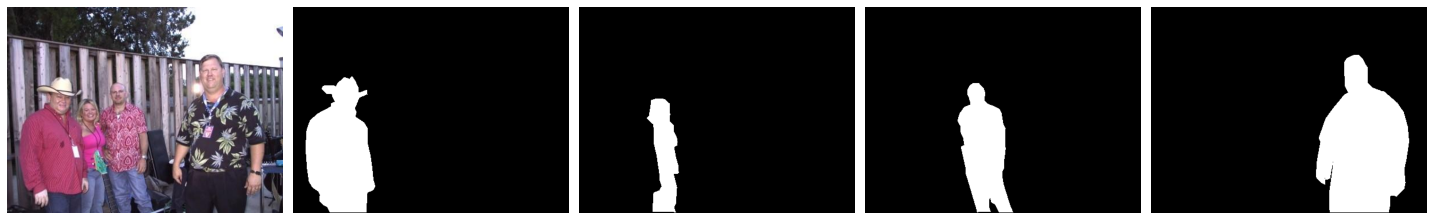

In [7]:
f = 'ADE_train_00014301'

# input image
im = read(find(f, all_images), 1)
print(im.shape)

# annotation image shape = (3, H, W)
an = read(find(f, all_annots), 1).transpose(2, 0, 1)
r, g, b = an

# r indicates the class
# like semantic segmentation annotations?
nzs = np.nonzero(r == 4)  # 4 stands for person

# g is an instance segmentation indicator
# b is not used
# `instances` is the number of people in the input image!
instances = np.unique(g[nzs])

# the shape of maks = (# of instances, H, W)
# what is the dtype? it's float64.
masks = np.zeros((len(instances), *r.shape))
for ix,_id in enumerate(instances):
    masks[ix] = (g == _id)

subplots([im, *masks], sz=20)

In [35]:
# take only annotations have non-zero person in them
annots = []

# all_annots is a list of annotation file paths
for ann in Tqdm(all_annots):
    _ann = read(ann, 1).transpose(2, 0, 1)
    r, g, b = _ann
    
    # takes if 'person' class pixel exists
    if 4 not in np.unique(r):
        continue

    annots.append(ann)

100%|████████████████████████████████████████████████████████████████████| 20210/20210 [01:10<00:00, 285.82it/s]


In [36]:
from sklearn.model_selection import train_test_split


_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

In [37]:
def get_transform(train):
    transforms = []
    # note that T is not torchvision.transforms
    transforms.append(T.ToTensor())
    
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

#### MasksDataset
- it reads input images and corresponding mask images using `PIL.Image.open`
- MasksDataset.transforms converts `PIL.Image.Image` to `torch.Tensor`
- it constructs targets dynamically
    - would it be better to stores them in memory in the tensor form?
        - if we don't have too much of data

In [38]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        """
        Args:
            items (List[str]): stem of input and annotation images
            transforms:
            N (int): the length of this Dataset
        """
        self.items = items
        self.transforms = transforms
        self.N = N

    def get_mask(self, path):
        """
        this method could be static
        """
        # torch_snippets.loader.read uses cv2.imread
        # mode = 1 returns an image in a RGB format
        # pytorch requires the color channel first. Thus, transpose
        an = read(path, 1).transpose(2, 0, 1)
        
        # this only possible when the color channel comes first
        r, g, b = an
        
        # r == 4 => all people instances!
        nzs = np.nonzero(r == 4)
        
        # does it start from 0 or 1?
        instances = np.unique(g[nzs])
        
        # the shape of mask is (# of people,H, W)
        masks = np.zeros((len(instances), *r.shape))

        for ix, _id in enumerate(instances):
            masks[ix] = (g == _id)

        return masks

    def __getitem__(self, ix):
        """
        this method gives only a 'person' class sample
        
        Returns:
            (image, dict of list of boxes, labels, masks, etc)
        """
        # _id is stem
        _id = self.items[ix]
        img_path = f'../data/ChallengeData2017/images/training/{_id}.jpg'
        mask_path = f'../data/ChallengeData2017/annotations_instance/training/{_id}.png'
        
        # masks.shape = (# of people, H, W)
        masks = self.get_mask(mask_path)
#         obj_ids = np.arange(1, len(masks) + 1)
#         num_objs = len(obj_ids)
        num_objs = len(masks)
        
        # input image shape = (3, H, W)
        img = Image.open(img_path).convert("RGB")
        
        # this bounding boxes are calculated from masks
        # # of boxes == # of people
        boxes = []
        for i in range(num_objs):
            # non-zero pixel indices
            obj_pixels = np.where(masks[i])
            
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            
            if ((xmax - xmin) <= 10) | (ymax - ymin) <= 10:
                xmax = xmin + 10
                ymax = ymin + 10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # we have only one non-background (person) class in this dataset
        # thus, labels are all 1
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        # shape = (# of people, H, W)
        # does python require masks be uint8 tensors?
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        # shape = (# of people,)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # what is 'iscrowd'?
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        # image_id should be a uint64 tensor?
        image_id = torch.tensor([ix])
        
        target = {"boxes": boxes, "labels": labels, "masks": masks,
                  "image_id": image_id, "area": area, "iscrowd": iscrowd}

        # just a unique number? shape = (1,)

        if self.transforms is not None:
            # it transforms also all images in `target` too?
            img, target = self.transforms(img, target)
        return img, target
    
    def __len__(self):
        return self.N
    
    def choose(self):
        return self[randint(len(self))]


#### some datatype and shape checking
- so many keys in target dicts
    - `boxes`, `masks`, `labels`, `area`, `image_id`, `iscrowd`
    - which are required and which are optional?
- note that `image_id` is a tensor of size [1].
- all other tensors have `size(0)` of the number of instances

<class 'torch.Tensor'> torch.Size([3, 512, 683]) ['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd']
boxes dtype: torch.float32
labels dtype: torch.int64
masks dtype : torch.uint8
image_id: torch.int64
area: torch.float32
iscrowd: torch.int64


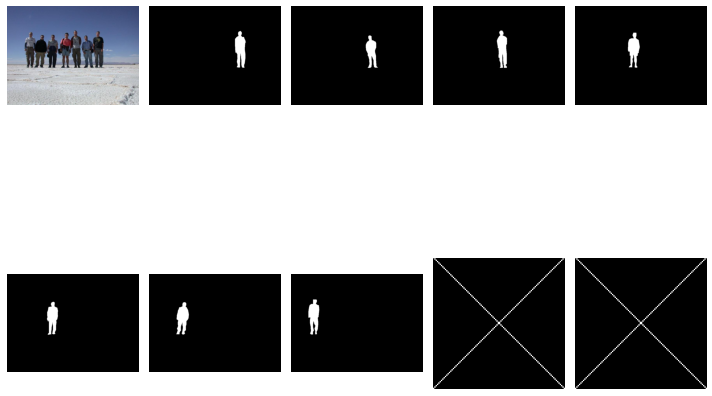

In [39]:
# trn_items are stems of image files
# MaskDataset gives a tuple of (image, dict of list of boxes, list of labels, list of masks, ...)
x = MasksDataset(trn_items, get_transform(train=True), N=100)
# the second image and its target
im, targ = x[1]
print(type(im), im.shape, list(targ.keys()))
# inspect(im, targ)

# except masks (torch.uint8) all integers are torch.uint64
print('boxes dtype:', targ['boxes'].dtype)
print('labels dtype:', targ['labels'].dtype)
print('masks dtype :', targ['masks'].dtype)

# since it's for a single image, a singular term makes sense
print('image_id:', targ['image_id'].dtype)
# why singular 'area'? not 'areas'
print('area:', targ['area'].dtype)
# why 'iscrowd' not ''
print('iscrowd:', targ['iscrowd'].dtype)

subplots([im, *targ['masks']], sz=10)

In [11]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [40]:
# MasksDataset takes a list of stems and a custom transform
dataset = MasksDataset(trn_items, get_transform(train=True), N=3000)
dataset_test = MasksDataset(val_items, get_transform(train=False), N=800)

# define training and validation data loaders
# `utils.collate_fn` is basically a transpose
# (list of images), (list of targets) -> list of (image, targe)
# actually, it's a typical thing to do but types of y is different from typical caes
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)


x, y = next(iter(data_loader))
# x are 2 images note that batch_size is 2
# y are 2 targets. Each target is a dict of boxes, labels, masks, and etc.
print(len(x))

# # of boxes is # of instances
# shape = (# of instances, 4)!
print(y[0]['boxes'])
# all instances are in the same class (person)
print(y[0]['labels'])
# the shape of 'masks' is (# of instances, H, W)
print(y[0]['masks'].shape)
print(y[0]['masks'].dtype)


2
tensor([[ 63., 442., 119., 462.],
        [424., 442., 436., 472.],
        [320., 445., 326., 466.]])
tensor([1, 1, 1])
torch.Size([3, 683, 512])
torch.uint8


In [13]:
num_classes = 2
model = get_model_instance_segmentation(num_classes).to(device)

# SGD takes only parameters which requires_grad
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3, gamma=0.1)

In [14]:
num_epochs = 1

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/1500]  eta: 0:18:01  lr: 0.000010  loss: 4.9155 (4.9155)  loss_classifier: 1.0053 (1.0053)  loss_box_reg: 0.2281 (0.2281)  loss_mask: 3.6682 (3.6682)  loss_objectness: 0.0126 (0.0126)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 0.7213  data: 0.0457  max mem: 2361
Epoch: [0]  [  10/1500]  eta: 0:15:58  lr: 0.000060  loss: 3.8032 (3.7316)  loss_classifier: 0.8912 (0.8950)  loss_box_reg: 0.2885 (0.2959)  loss_mask: 2.4639 (2.4846)  loss_objectness: 0.0325 (0.0399)  loss_rpn_box_reg: 0.0106 (0.0162)  time: 0.6436  data: 0.0308  max mem: 3313
Epoch: [0]  [  20/1500]  eta: 0:15:17  lr: 0.000110  loss: 2.6546 (2.9029)  loss_classifier: 0.6576 (0.6999)  loss_box_reg: 0.2885 (0.3019)  loss_mask: 1.5587 (1.8211)  loss_objectness: 0.0317 (0.0582)  loss_rpn_box_reg: 0.0106 (0.0218)  time: 0.6145  data: 0.0296  max mem: 3313
Epoch: [0]  [  30/1500]  eta: 0:15:08  lr: 0.000160  loss: 1.5950 (2.4261)  loss_classifier: 0.3744 (0.5789)  loss_box_reg: 0.3269 (0.3388)  loss_mask: 0.6914 (

Epoch: [0]  [ 300/1500]  eta: 0:13:14  lr: 0.001508  loss: 0.6351 (0.9652)  loss_classifier: 0.0950 (0.1791)  loss_box_reg: 0.1459 (0.2574)  loss_mask: 0.3135 (0.4563)  loss_objectness: 0.0170 (0.0462)  loss_rpn_box_reg: 0.0078 (0.0262)  time: 0.6784  data: 0.0314  max mem: 3973
Epoch: [0]  [ 310/1500]  eta: 0:13:10  lr: 0.001558  loss: 0.6109 (0.9539)  loss_classifier: 0.0893 (0.1764)  loss_box_reg: 0.1626 (0.2552)  loss_mask: 0.3135 (0.4513)  loss_objectness: 0.0089 (0.0450)  loss_rpn_box_reg: 0.0080 (0.0259)  time: 0.7189  data: 0.0376  max mem: 3973
Epoch: [0]  [ 320/1500]  eta: 0:13:03  lr: 0.001608  loss: 0.6059 (0.9488)  loss_classifier: 0.0875 (0.1751)  loss_box_reg: 0.1368 (0.2538)  loss_mask: 0.2919 (0.4474)  loss_objectness: 0.0118 (0.0464)  loss_rpn_box_reg: 0.0095 (0.0262)  time: 0.7016  data: 0.0381  max mem: 3973
Epoch: [0]  [ 330/1500]  eta: 0:12:56  lr: 0.001658  loss: 0.6592 (0.9432)  loss_classifier: 0.0988 (0.1735)  loss_box_reg: 0.1418 (0.2512)  loss_mask: 0.3406 (

Epoch: [0]  [ 600/1500]  eta: 0:10:06  lr: 0.003007  loss: 0.5792 (0.8265)  loss_classifier: 0.0996 (0.1466)  loss_box_reg: 0.1306 (0.2210)  loss_mask: 0.3240 (0.3949)  loss_objectness: 0.0126 (0.0394)  loss_rpn_box_reg: 0.0063 (0.0245)  time: 0.6717  data: 0.0255  max mem: 3973
Epoch: [0]  [ 610/1500]  eta: 0:10:00  lr: 0.003057  loss: 0.6543 (0.8249)  loss_classifier: 0.1145 (0.1463)  loss_box_reg: 0.1689 (0.2206)  loss_mask: 0.3319 (0.3942)  loss_objectness: 0.0158 (0.0393)  loss_rpn_box_reg: 0.0144 (0.0245)  time: 0.6988  data: 0.0352  max mem: 3973
Epoch: [0]  [ 620/1500]  eta: 0:09:54  lr: 0.003107  loss: 0.6824 (0.8253)  loss_classifier: 0.1129 (0.1464)  loss_box_reg: 0.1893 (0.2209)  loss_mask: 0.3457 (0.3940)  loss_objectness: 0.0217 (0.0393)  loss_rpn_box_reg: 0.0207 (0.0246)  time: 0.7281  data: 0.0526  max mem: 3973
Epoch: [0]  [ 630/1500]  eta: 0:09:47  lr: 0.003157  loss: 0.6485 (0.8221)  loss_classifier: 0.1086 (0.1454)  loss_box_reg: 0.1134 (0.2194)  loss_mask: 0.3426 (

Epoch: [0]  [ 900/1500]  eta: 0:06:46  lr: 0.004505  loss: 0.6212 (0.7816)  loss_classifier: 0.0809 (0.1363)  loss_box_reg: 0.1253 (0.2082)  loss_mask: 0.3077 (0.3760)  loss_objectness: 0.0249 (0.0366)  loss_rpn_box_reg: 0.0117 (0.0247)  time: 0.6657  data: 0.0461  max mem: 3973
Epoch: [0]  [ 910/1500]  eta: 0:06:39  lr: 0.004555  loss: 0.5169 (0.7803)  loss_classifier: 0.0701 (0.1359)  loss_box_reg: 0.0902 (0.2076)  loss_mask: 0.3391 (0.3754)  loss_objectness: 0.0175 (0.0366)  loss_rpn_box_reg: 0.0066 (0.0247)  time: 0.6411  data: 0.0346  max mem: 3973
Epoch: [0]  [ 920/1500]  eta: 0:06:32  lr: 0.004605  loss: 0.6901 (0.7798)  loss_classifier: 0.0942 (0.1357)  loss_box_reg: 0.1541 (0.2074)  loss_mask: 0.3412 (0.3755)  loss_objectness: 0.0244 (0.0365)  loss_rpn_box_reg: 0.0137 (0.0247)  time: 0.6528  data: 0.0314  max mem: 3973
Epoch: [0]  [ 930/1500]  eta: 0:06:25  lr: 0.004655  loss: 0.6901 (0.7777)  loss_classifier: 0.0839 (0.1352)  loss_box_reg: 0.1403 (0.2068)  loss_mask: 0.3181 (

Epoch: [0]  [1200/1500]  eta: 0:03:23  lr: 0.005000  loss: 0.6374 (0.7641)  loss_classifier: 0.1117 (0.1327)  loss_box_reg: 0.2212 (0.2023)  loss_mask: 0.3132 (0.3663)  loss_objectness: 0.0230 (0.0381)  loss_rpn_box_reg: 0.0123 (0.0248)  time: 0.6907  data: 0.0445  max mem: 3973
Epoch: [0]  [1210/1500]  eta: 0:03:16  lr: 0.005000  loss: 0.7120 (0.7632)  loss_classifier: 0.1287 (0.1326)  loss_box_reg: 0.2559 (0.2024)  loss_mask: 0.3031 (0.3658)  loss_objectness: 0.0111 (0.0378)  loss_rpn_box_reg: 0.0116 (0.0247)  time: 0.6876  data: 0.0341  max mem: 3973
Epoch: [0]  [1220/1500]  eta: 0:03:09  lr: 0.005000  loss: 0.6338 (0.7624)  loss_classifier: 0.1093 (0.1323)  loss_box_reg: 0.1773 (0.2020)  loss_mask: 0.3052 (0.3657)  loss_objectness: 0.0099 (0.0377)  loss_rpn_box_reg: 0.0063 (0.0248)  time: 0.6730  data: 0.0340  max mem: 3973
Epoch: [0]  [1230/1500]  eta: 0:03:02  lr: 0.005000  loss: 0.5547 (0.7609)  loss_classifier: 0.0978 (0.1320)  loss_box_reg: 0.1321 (0.2017)  loss_mask: 0.3052 (

Epoch: [0]  [1499/1500]  eta: 0:00:00  lr: 0.005000  loss: 0.7033 (0.7567)  loss_classifier: 0.1076 (0.1321)  loss_box_reg: 0.1884 (0.2017)  loss_mask: 0.3220 (0.3607)  loss_objectness: 0.0136 (0.0372)  loss_rpn_box_reg: 0.0127 (0.0250)  time: 0.7115  data: 0.0445  max mem: 3973
Epoch: [0] Total time: 0:17:01 (0.6807 s / it)
creating index...
index created!
Test:  [  0/800]  eta: 0:03:24  model_time: 0.1835 (0.1835)  evaluator_time: 0.0497 (0.0497)  time: 0.2559  data: 0.0061  max mem: 3973
Test:  [100/800]  eta: 0:02:43  model_time: 0.1325 (0.1577)  evaluator_time: 0.0271 (0.0513)  time: 0.2037  data: 0.0161  max mem: 3973
Test:  [200/800]  eta: 0:02:20  model_time: 0.1379 (0.1593)  evaluator_time: 0.0295 (0.0520)  time: 0.2161  data: 0.0154  max mem: 3973
Test:  [300/800]  eta: 0:02:00  model_time: 0.1308 (0.1595)  evaluator_time: 0.0291 (0.0553)  time: 0.3061  data: 0.0577  max mem: 3973
Test:  [400/800]  eta: 0:01:37  model_time: 0.1458 (0.1607)  evaluator_time: 0.0318 (0.0565)  ti

#### prediction
- 2 classes (background, person)
- the output is the list of dicts
    - one dict per image
        - this dict has 'boxes', 'scores', 'labels', 'masks'
        - 'boxes', 'scores', 'labels', 'masks' are lists
        - all lengths of these lists are the number of found instances

In [ ]:
model.eval()
# model(dataset[0][0])
print('image shape =', dataset[0][0].shape)
pred, = model(dataset[0][0].unsqueeze(dim=0).to(device))
print('key names :', pred.keys())

# one box per instance
# print(pred['boxes'].shape)
print(pred['boxes'][0])

# the model gives only the scores for the most probable labels
#     not the scores for all classes
# thus, the shape = (# of instances,)
print('scores :', pred['scores'])

# does the model ever give 0 (background) labels?
print(pred['labels'])

print(pred['masks'].shape)

# subplots can't draw a single image!
subplots([dataset[0][0], dataset[1][0]])

image shape = torch.Size([3, 512, 683])


### 2. PennFudan dataset
- maks rcnn training on custom dataset
    - detecting pedestrians
- I think you need to get some python modules from pytorchvision repository
    - engine.py, utils.py, transforms.py, coco_eval.py, coco_utils.py
    - make sure to get from the exactly same version repository
- data at [here](https://www.cis.upenn.edu/~jshi/ped_html/)

In [9]:
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # note that all values of this dictionary are torch Tensors!
        target = {"boxes": boxes, "labels": labels, "masks": masks,
                  "image_id": image_id, "area": area, "iscrowd": iscrowd}

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    # should I set requires_grad = False for the backbone?
    for param in model.parameters():
        param.requires_grad = False

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [12]:
import transforms as T


def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

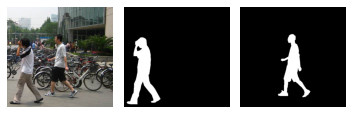

In [26]:
import matplotlib.pyplot as plt

%matplotlib inline

ds = PennFudanDataset('PennFudanPed', get_transform(train=True))

sample = ds[8]
img = sample[0].detach().numpy()
annotation = sample[1]

img = np.moveaxis(img, 0, 2)
mask1 = annotation['masks'][0].detach().numpy()
mask2 = annotation['masks'][1].detach().numpy()

# fig, ax = plt.subplots(1, 3)

# ax[0].imshow(img)
# ax[1].imshow(mask1, cmap='Greys')
# ax[2].imshow(mask2, cmap='Greys')

# torch_snippets.subplots
subplots([img, mask1, mask2])


In [30]:
# print(ds[0][1]['boxes'])
for _, target in ds:
    print(target['boxes'].shape)

torch.Size([2, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([3, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([2, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([3, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([2, 4])
torch.Size([1, 4])
torch.Size([3, 4])
torch.Size([2, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([6, 4])
torch.Size([2, 4])
torch.Size([1, 4])
torch.Size([2, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([4, 4])
torch.Size([2, 4])
torch.Size([1, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([3, 4])
torch.Size([2, 4])
torch.Size([3, 4])
torch.Size([4, 4])
torch.Size([3, 4])
torch.Size([4, 4])
torch.Size([3, 4])
torch.Size([4, 4])
torch.Size([3, 4])
torch.Size([2, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

In [ ]:
from engine import train_one_epoch, evaluate
import utils


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    # 120:50 split
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    # utils.collate_fn transforms
    #    list of (imge, annotations) -> (list of images, list of annotations)
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")
